A simple local circuit with interacting populations of excitatory and inhibitory neurons. - Sean Froudist-Walsh & Daniel Margulies. March 2019

In [168]:
%matplotlib inline
from __future__ import division
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas
import scipy.io as sio
import brian2
import os
import copy

Define the function that transforms input current to changes in firing rate for excitatory neurons (Abbott and Chance, 2005). 
<br>
$$r_E = \frac{aI_{syn,E} - b}{1 - e^{-d(aI_{syn,E} - b)}} $$

Update the firing rates of the interneurons using a threshold linear input/output function
$$ \begin{cases}
  r_I = \frac{1}{g_2}(c_II_{syn,I} - c_0) + r_0 & \text{for } r_I\ge 0\\    
  r_I = 0     & \text{otherwise }  
\end{cases} $$



In [169]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        return current_to_frequency_E(input_current,parameters['a_E'],parameters['b_E'],parameters['d_E'])
    if population_type == 'I':
        return current_to_frequency_I(input_current,parameters['c_I'],parameters['r0_I'])

def current_to_frequency_E(input_current1,a,b,d):
    return np.divide((a*input_current1 - b),(1 - np.exp(-d*(a*input_current1 - b))))

def current_to_frequency_I(input_current1,c_I,r_0):
    return np.maximum(c_I*input_current1 + r_0,0) 

Define the NMDA derivative
<br>
$$ \frac{dS_{NMDA}}{dt} = -\frac{S_{NMDA}}{\tau_{NMDA}} + (1 - S_{NMDA})\gamma r_E$$
(Wong & Wang, 2006)

In [170]:
def NMDA_deriv(S_NMDA_prev,rate_now,parameters):
    
    return -S_NMDA_prev/parameters['tau_NMDA'] + parameters['gam']*(1 - S_NMDA_prev)*rate_now

Define the GABA derivative
<br>
$$ \frac{dS_{GABA}}{dt} = -\frac{S_{GABA}}{\tau_{GABA}} + \gamma_Ir_I$$
(Wong & Wang, 2006)

In [171]:
def GABA_deriv(S_GABA_prev,rate_now,parameters):

    return -S_GABA_prev/parameters['tau_GABA'] + rate_now 

### Model:

In [255]:
#g_E_self, g_IE, g_I_self, g_EI
g_E_self=0.39
g_IE=0.23
g_I_self=-0.05
g_EI=-0.4

parameters = {}

parameters.update({ # Time constants
                    'tau_NMDA': 0.06   * brian2.second,    # s 
                    'tau_AMPA': 0.002   * brian2.second,    # s 
                    'tau_GABA': 0.005  * brian2.second,    # s 
                    'tau_rates': 0.002 * brian2.second,    # s 

                    # f-I curve parameters - E populations
                    'a_E': 270.  * brian2.Hz/brian2.nA / 2.,  # Hz/nA
                    'b_E': 108.  * brian2.Hz / 2.,            # Hz
                    'd_E': 0.154 * brian2.second * 2.,        # s
                    'gam': 0.641 * 2.,                         # unitless

                    # f-I curve parameters - I populations
                    'c_I': 330 * brian2.Hz/brian2.nA,                 # Hz/nA
                    'r0_I': -95 * brian2.Hz,

                    # Strength of connections from E cells
                    'g_E_self': g_E_self * brian2.nA ,        # nA - from E to E
                    'g_IE': g_IE * brian2.nA ,            # nA - from E to I

                    # Strength of connections from I cells
                    'g_I_self': g_I_self  * brian2.nA,     # nA  - from I to I
                    'g_EI': g_EI * brian2.nA,     # nA  - from I to E

                    # Strength of long range connections
                    'g_E_longRange': 0.18 * brian2.nA,
                    
                    # Background inputs
                    'I0_E': 0.20     * brian2.nA,           # nA - background onto E population
                    'I0_I': 0.18      * brian2.nA,         # nA - background onto I population

                    # Noise std dev
                    'std_noise': 0.01 * brian2.nA,         # nA  - standard deviation of noise input  

                    # initial values
                    'r0_E': 5 * brian2.Hz,

                    # stimulus strength
                    'stim_strength': 0.2 * brian2.nA
    
                
                        })      

######## LOCAL CONNECTIVITY MATRIX ########
J =  np.array([
                [parameters['g_E_self'] , parameters['g_EI']],
                [parameters['g_IE'] , parameters['g_I_self']]

              ]) * brian2.amp

pops = ['E','I']
pops_column_list  = ['from '+ mystring for mystring in pops]
pops_row_list  = ['to '+ mystring for mystring in pops]

J_NMDA = J*((J>0).astype(np.int))
J_GABA = J*((J<0).astype(np.int))

df_J = pandas.DataFrame(J, columns=pops_column_list, index=pops_row_list)

num_pops  = J.shape[0]
num_vertices = 25

# Choose initial values for rates and synapse variables
R0 = np.ones((num_vertices, num_pops))
R0 = R0 * parameters['r0_E']
S_NMDA0 = np.ones((num_vertices,num_pops)) * 0.1
S_GABA0 = np.zeros((num_vertices,num_pops))

#### Set up simulation details
# Set up simulation parameters
dt=0.5 * brian2.ms  # timestep 
trial_length=5000 * brian2.ms # trial length (s)
num_iterations = int(trial_length/dt)
time = np.arange(0, trial_length, dt)


# Preassign rate and synapse matrices
R           = np.zeros((num_iterations,num_vertices,num_pops)) * brian2.Hz
R[0,:,:]      = R0
S_NMDA      = np.zeros((num_iterations,num_vertices,num_pops))
S_NMDA[0,:,:] = S_NMDA0
S_GABA      = np.zeros((num_iterations,num_vertices,num_pops))
S_GABA[0,:,:] = S_GABA0

# # Preassign external inputs
I_ext        = np.zeros((num_iterations,num_vertices,num_pops)) * brian2.amp
stim_on      = 1 * brian2.second #s
stim_off     = 1.5 * brian2.second #s

# Let's apply external stimulation to V1 populations E1 & E2
V1_index = 0
I_ext[int(stim_on/dt):int(stim_off/dt),V1_index,0] = parameters['stim_strength']

# Create matrices in which we can store the currents
I_longRange_NMDA = np.zeros((num_iterations,num_vertices,num_pops)) * brian2.pA
I_local_NMDA =  np.zeros((num_iterations,num_vertices,num_pops)) * brian2.pA
I_local_GABA =  np.zeros((num_iterations,num_vertices,num_pops)) * brian2.pA
I_total      =  np.zeros((num_iterations,num_vertices,num_pops)) * brian2.pA
I_noise      =  np.zeros((num_vertices,num_pops)) * brian2.pA

# # Define background inputs
I_0 = np.zeros((num_vertices, num_pops)) * brian2.pA
I_0[:,pops.index('E')] = parameters['I0_E']
I_0[:,pops.index('I')] = parameters['I0_I']

# Let's set up the noise. We will model the noise as an Ornstein-Uhlenbeck process.
# https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process

# Gaussian noise. mean 0, std 1. Dims: timesteps, local populations, areas
eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations,num_vertices,num_pops))

# prepare the right hand side of the above equation
noise_rhs = eta*((np.sqrt(parameters['tau_AMPA']*np.power(parameters['std_noise'],2))*np.sqrt(dt))/parameters['tau_AMPA'])

#print(I_0)

In [250]:
# Connectivity
import numpy as np
edges = {}
num_nodes = 25
for i in range(num_nodes):
    e = []
    if i >= np.sqrt(num_nodes):
        e.append(i-np.sqrt(num_nodes))
    if i < num_nodes-np.sqrt(num_nodes):
        e.append(i+np.sqrt(num_nodes))
    if i % np.sqrt(num_nodes) != 0:
        e.append(i-1)
    if i % np.sqrt(num_nodes) != np.sqrt(num_nodes)-1:
        e.append(i+1)
    edges.update({
        str(i): [int(j) for j in e]
    })
connectivity = np.zeros((num_nodes,num_nodes))
for i in range(num_nodes):
    connectivity[i,edges[str(i)]] = 1
'''
# check connectivity:
import matplotlib.pylab as plt
for i in range(num_nodes):
    plt.imshow(np.reshape(connectivity[:,i],(5,5)))
    plt.show()
'''

'\n# check connectivity:\nimport matplotlib.pylab as plt\nfor i in range(num_nodes):\n    plt.imshow(np.reshape(connectivity[:,i],(5,5)))\n    plt.show()\n'

In [251]:
#### Run model:
for i_t in range(1,num_iterations):

    # update noise - dims = num local pops x num areas
    I_noise = I_noise + -I_noise*(dt/parameters['tau_AMPA']) + noise_rhs[i_t-1,:,:]

    # long range NMDA
    I_longRange_NMDA[i_t-1,:,:] = parameters['g_E_longRange'] * connectivity.dot(S_NMDA[i_t-1,:,:])
    
    # local NMDA
    I_local_NMDA[i_t-1,:,:] = J_NMDA.dot(S_NMDA[i_t-1,:,:].T).T
    
    # sum up all the local GABA current onto E and I cell somas
    I_local_GABA[i_t-1,:,:] = J_GABA.dot(S_GABA[i_t-1,:,:].T).T

    # Define total input current as sum of local NMDA & GABA inputs, with background, external currents & noise & longRange
    I_total[i_t-1,:,:] = I_local_NMDA[i_t-1,:,:] +  I_local_GABA[i_t-1,:,:] + I_0 + I_ext[i_t-1,:,:] + I_noise + I_longRange_NMDA[i_t-1,:,:]

    # Update the firing rates of the excitatory population
    R[i_t,:,0] = R[i_t-1,:,0] + dt*current_to_frequency(I_total[i_t-1,:,0],'E',parameters)/parameters['tau_rates']-dt*R[i_t-1,:,0]/parameters['tau_rates']

    # Update the firing rates of the inhibitory population. 
    R[i_t,:,1] = R[i_t-1,:,1] + dt*current_to_frequency(I_total[i_t-1,:,1],'I',parameters)/parameters['tau_rates']-dt*R[i_t-1,:,1]/parameters['tau_rates']

    # Update the NMDA synapses
    S_NMDA[i_t,:,0] = S_NMDA[i_t-1,:,0] + dt*NMDA_deriv(S_NMDA[i_t-1,:,0],R[i_t,:,0],parameters)

    # Update the GABA synapses
    S_GABA[i_t,:,1] = S_GABA[i_t-1,:,1] + dt*GABA_deriv(S_GABA[i_t-1,:,1],R[i_t,:,1],parameters)


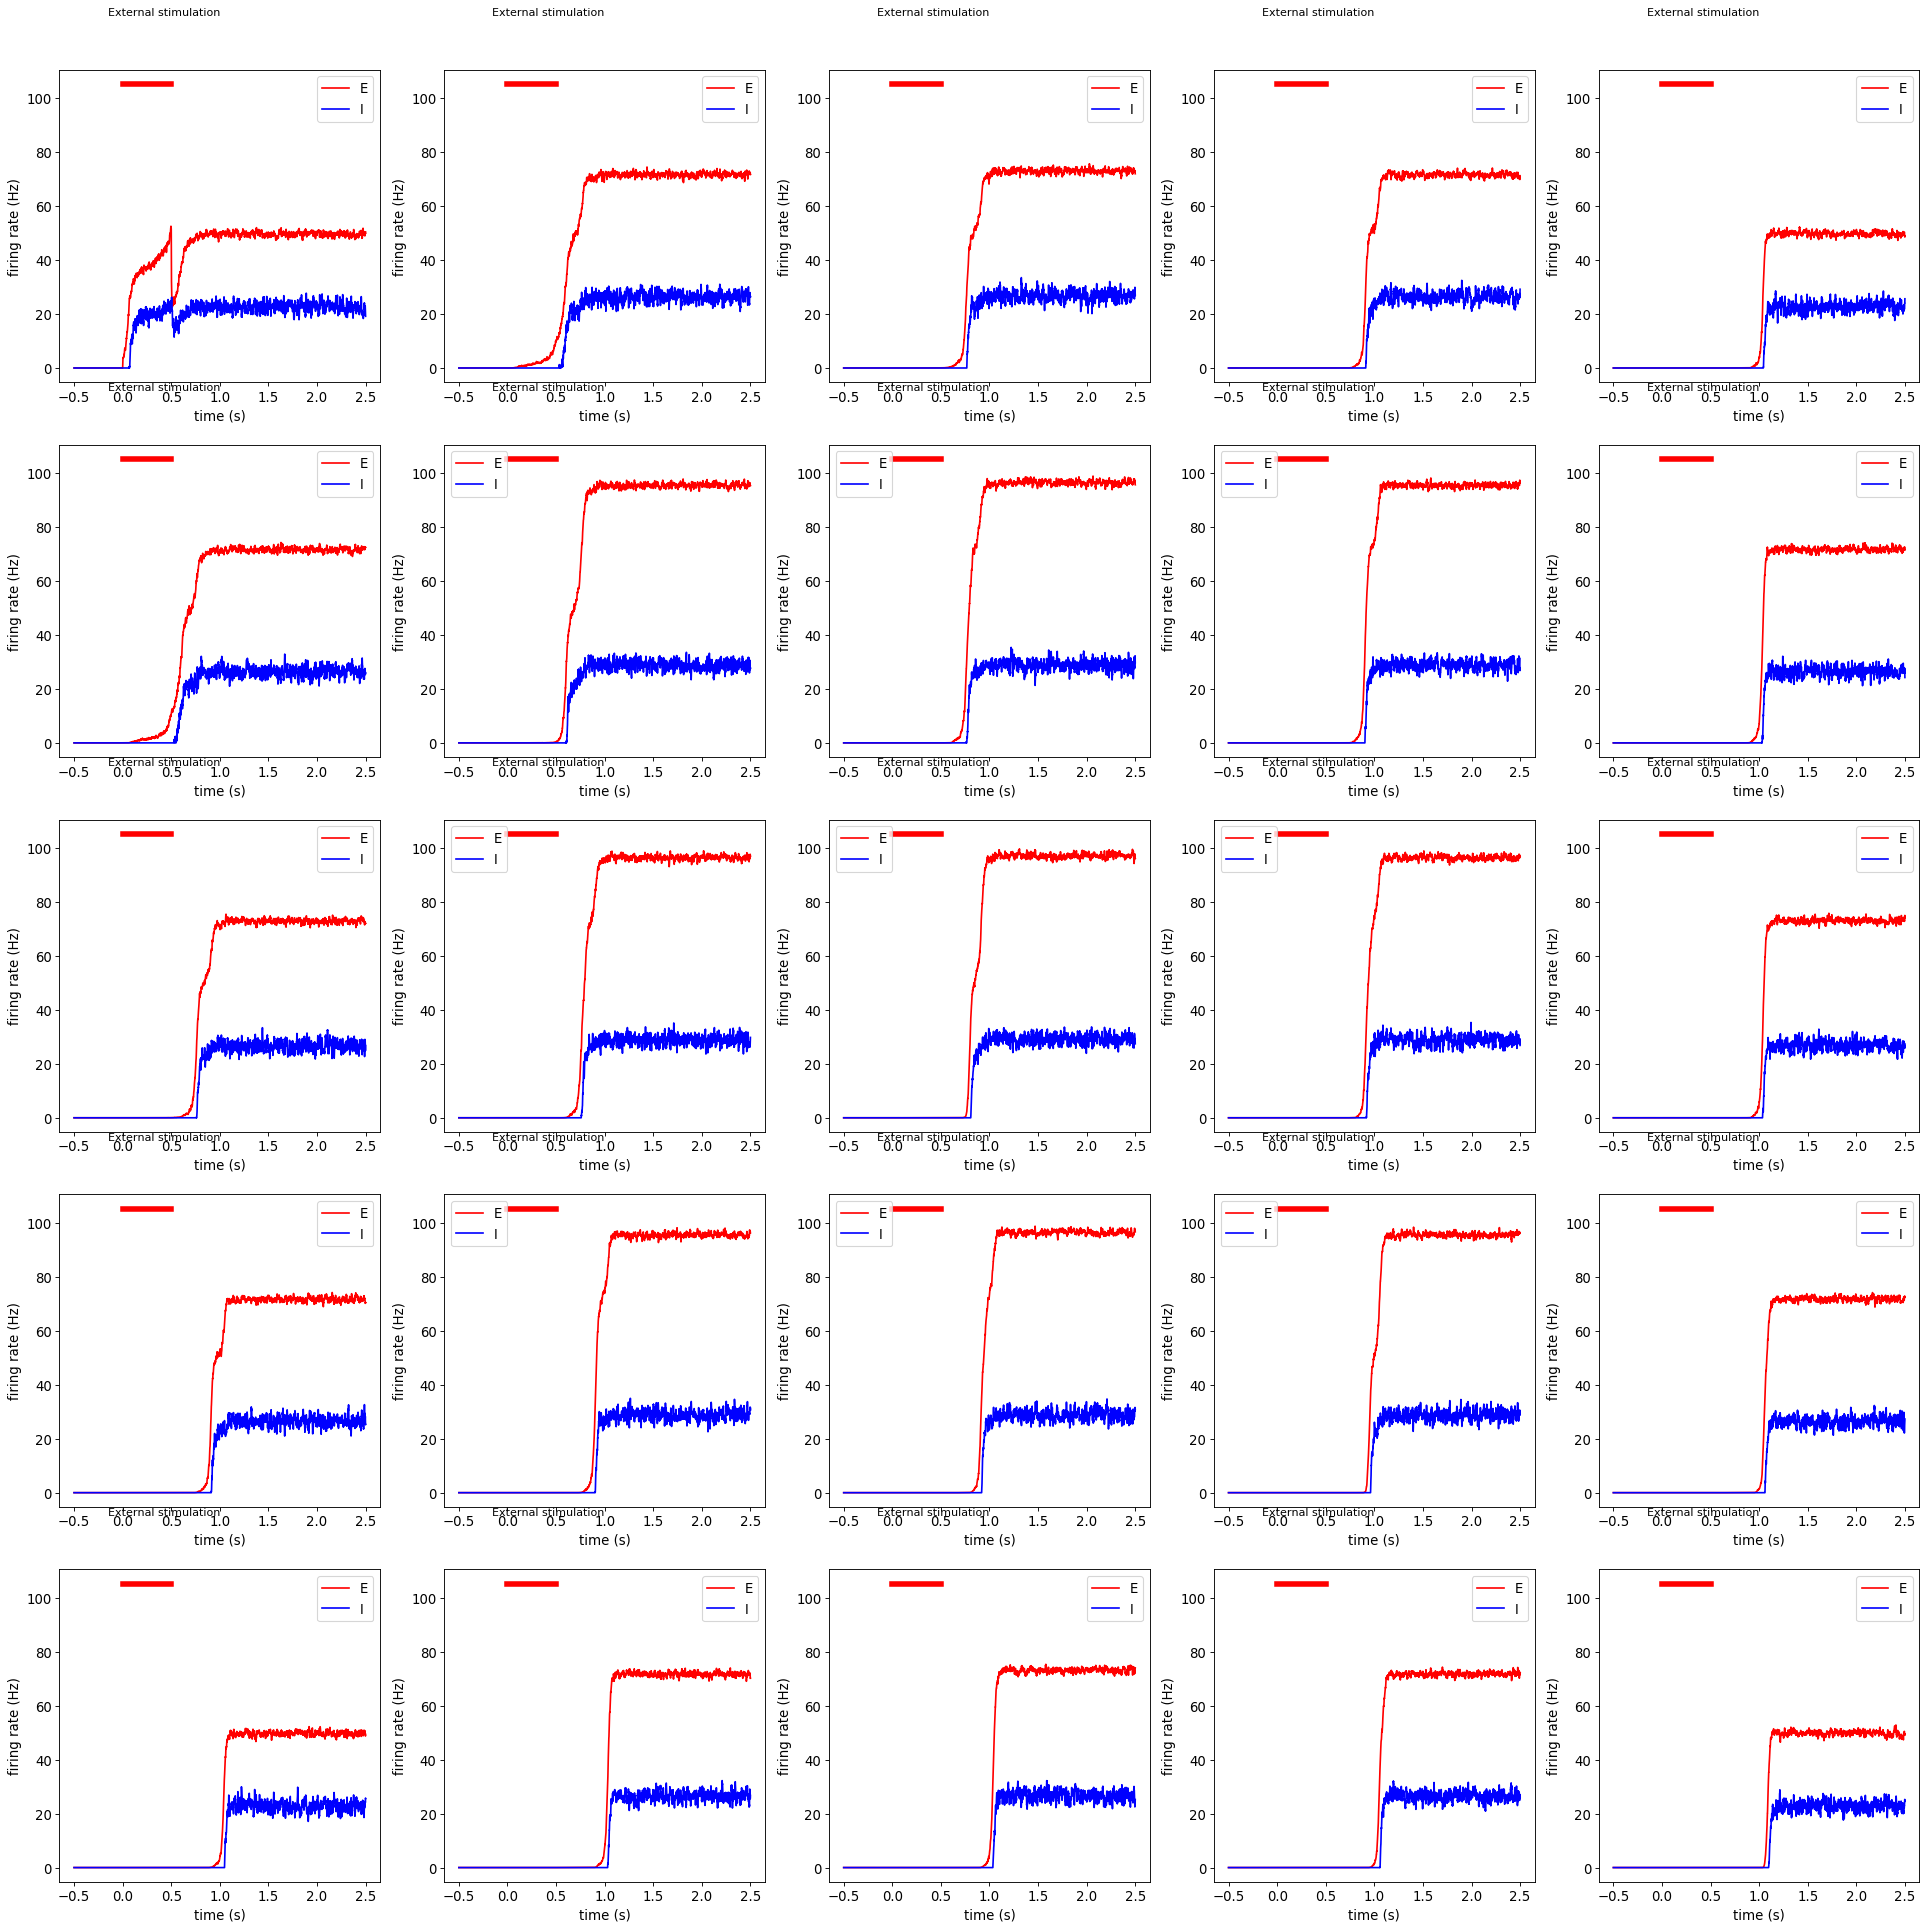

In [252]:
fig=plt.figure(figsize=(30,30), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
start_time = 0.5 #seconds
end_time = 3.5 #seconds

for i in range(1,num_vertices+1):
    ax = plt.subplot(np.sqrt(num_vertices), np.sqrt(num_vertices), i)    

    # Plot E population rates
    plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),i-1,0],color='r')
    # Plot I population rates
    plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),i-1,1],color='b')

    # Plot the stimulation time
    plt.plot([stim_on-1*brian2.second,stim_off-1*brian2.second],[np.max(R+0.05*np.max(R)),np.max(R+0.05*np.max(R))],color='r',linewidth=5.0)

    # place text above the stimulation line
    axes = plt.gca()
    axes.text(0.15, 1.2,'External stimulation', transform=axes.transAxes, fontsize=10, verticalalignment='top')

    plt.legend(['E','I'])
    plt.xlabel('time (s)')
    plt.ylabel('firing rate (Hz)')
    # plt.ylim(0, 80) 

plt.show()

In [254]:
# Notes (4.4.19):
# 1. increase inhibition firing rate compared to excitatory populations
# 2. AMPA receptors? 
# 3. Delays?
# 4. Mechanism such that firing dies off? Oscillating?
# 5. Bring in heterogeneity
# 6. real structural basis for connectivity data